## Import libaries

In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
import time
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
import random
import keras
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from IPython.display import display
from termcolor import colored
from tabulate import tabulate
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from sklearn.metrics import confusion_matrix,classification_report
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization
import tensorflow as tf 
sns.set_style('whitegrid')

## show a samples of each class

In [3]:
dir = r'/mnt/d/CODES/Jupyter_notebook/Deep Learning Projects/Rice_Classifcation/Rice_Image_Dataset'

detection = [class_name for class_name in os.listdir(dir) if class_name]

In [4]:
print(detection)

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag', 'Rice_Citation_Request.txt']


In [5]:
detection.remove('Rice_Citation_Request.txt')

In [6]:
print(detection)

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


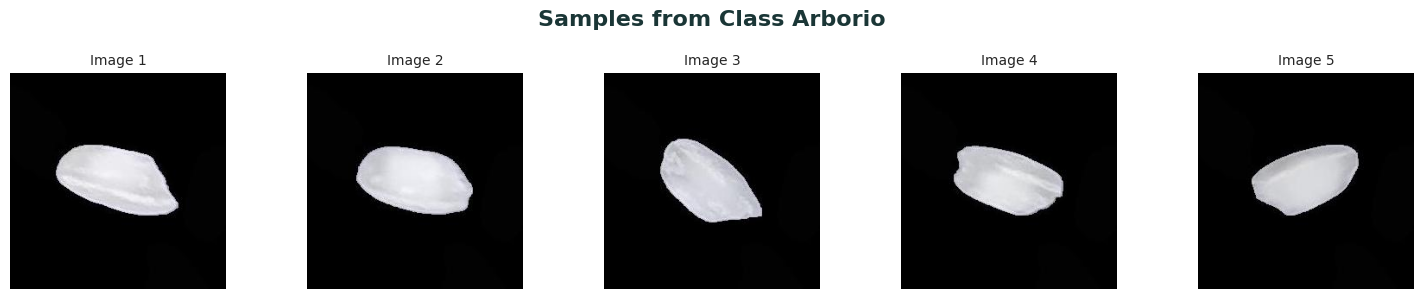

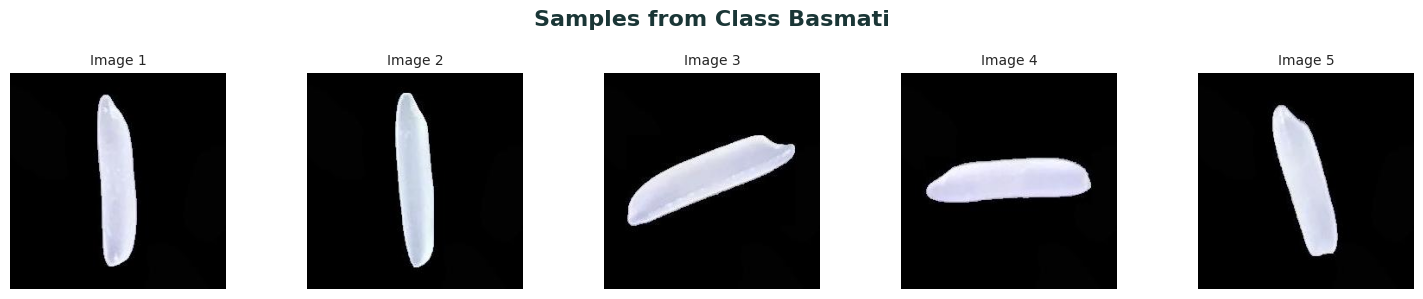

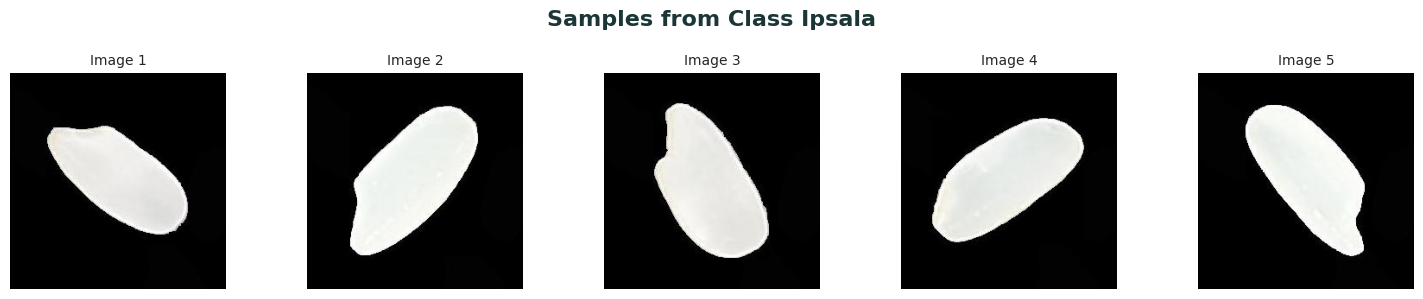

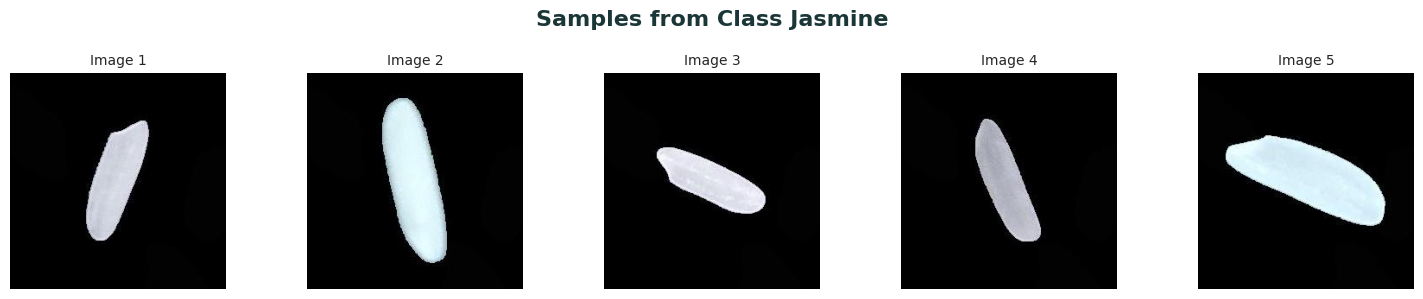

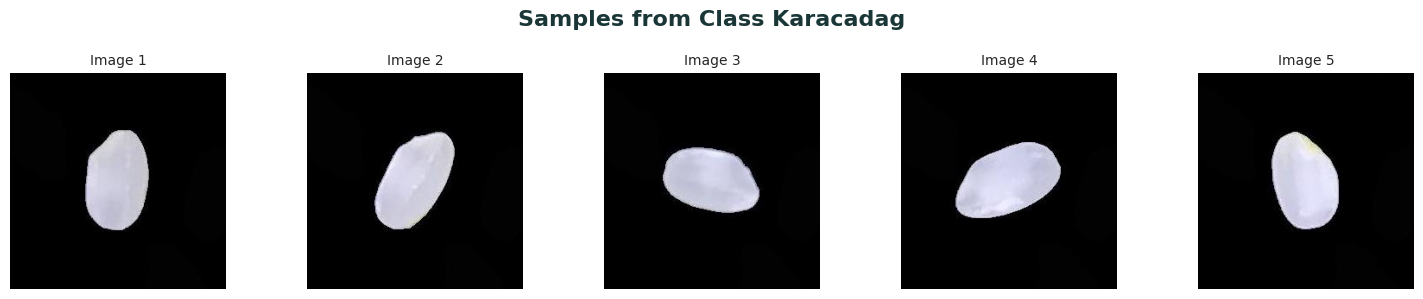

In [7]:
for class_name in detection:
    class_path = os.path.join(dir, class_name)

    images = os.listdir(class_path)
    random_images = random.choices(images, k=5)

    fig, ax = plt.subplots(1, 5, figsize=(15, 3))
    plt.suptitle(f"Samples from Class {class_name}", fontsize=16, fontweight='bold', color='#1A3636')

    for i in range(5):
        img_path = os.path.join(class_path, random_images[i])
        img = keras.utils.load_img(img_path)
        ax[i].imshow(img)
        ax[i].axis('off')
        ax[i].set_title(f"Image {i + 1}",fontsize=10)
    plt.tight_layout(rect=[0,0,1,0.95])

    plt.show()

## Count the images of each class

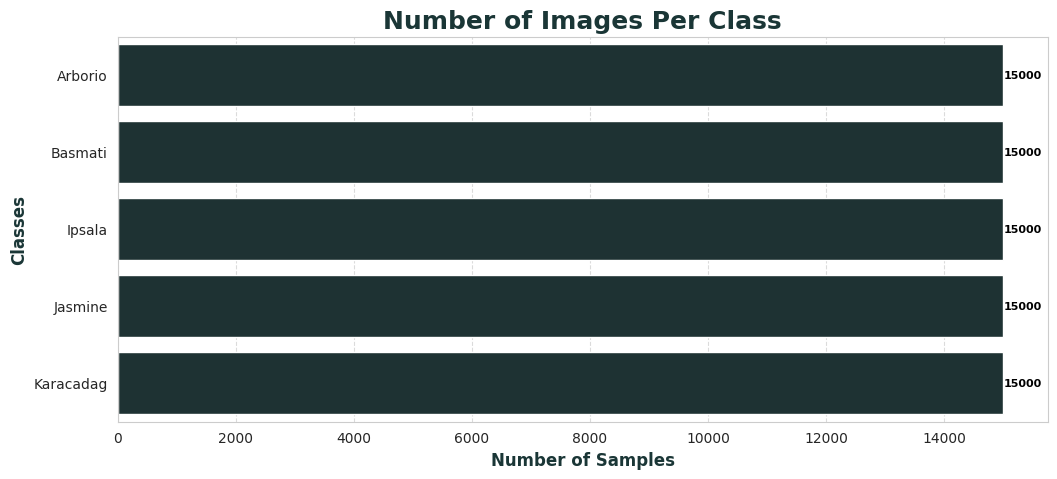

In [8]:
counts = []

for class_name in detection:
    class_path = os.path.join(dir,class_name)
    counts.append(len(os.listdir(class_path)))

plt.figure(figsize=(12,5))
palette = ['#1A3636' for _ in range(len(counts))]
ax = sns.barplot(y=detection,x=counts,palette=palette)

for i,p in enumerate(ax.patches):
    width = p.get_width()
    ax.text(width + 5, p.get_y() + p.get_height()/2,f'{counts[i]}',va ='center',fontsize = 8 , color = 'black',fontweight = 'bold')

plt.title("Number of Images Per Class",fontsize = 18 , fontweight = 'bold',color = '#1A3636')

plt.ylabel("Classes",fontsize = 12 , fontweight = 'bold',color = '#1A3636')

plt.xlabel('Number of Samples', fontsize=12, fontweight='bold', color='#1A3636')


plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

## create a tuples contain image and it's label

In [9]:
image_data = []

for class_name in detection:
    class_path = os.path.join(dir,class_name)
    files = os.listdir(class_path)

    for file in files:
        file_path = os.path.join(class_path,file)
        image_data.append((file_path,class_name))

df = pd.DataFrame(image_data,columns=['path','label'])
df = df.sample(frac=1).reset_index(drop = True)

display(df.head())

,path,label
0,/mnt/d/CODES/Jupyter_notebook/Deep Learning Pr...,Basmati
1,/mnt/d/CODES/Jupyter_notebook/Deep Learning Pr...,Karacadag
2,/mnt/d/CODES/Jupyter_notebook/Deep Learning Pr...,Jasmine
3,/mnt/d/CODES/Jupyter_notebook/Deep Learning Pr...,Ipsala
4,/mnt/d/CODES/Jupyter_notebook/Deep Learning Pr...,Basmati


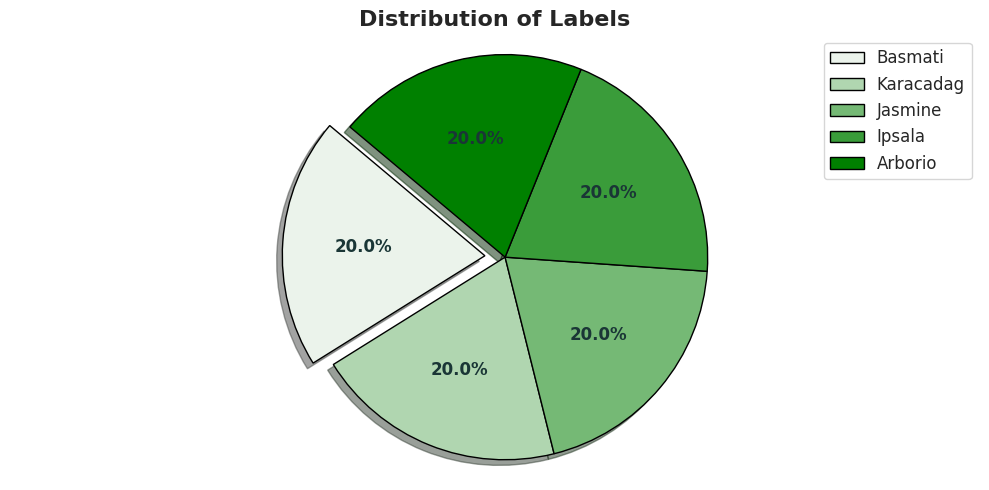

In [10]:
def label_counter(dataframe):
    fig,ax = plt.subplots(figsize = (10,5))
    labels = dataframe['label'].value_counts().index
    sizes = dataframe['label'].value_counts().values 

    colors = sns.light_palette('green',n_colors=len(labels),as_cmap=False)

    wedges, texts, autotexts = ax.pie(sizes, colors=colors, 
                                      autopct='%1.1f%%', startangle=140, 
                                      explode=(0.1, *([0] * (len(labels) - 1))), 
                                      wedgeprops=dict(edgecolor='black'), shadow=True)
    ax.set_title('Distribution of Labels', fontsize=16, fontweight='bold')
    ax.axis('equal')  
    
    # Create legend
    ax.legend(wedges, labels, loc="best", fontsize=12)

    for text in texts:
        text.set_fontsize(12)
        text.set_fontweight('bold')
        text.set_color('#1a3636')  

    for autotext in autotexts:
        autotext.set_fontsize(12)
        autotext.set_fontweight('bold')
        autotext.set_color('#1a3636') 

    plt.tight_layout()
    plt.show()


label_counter(df)

In [11]:
total_samples = len(df)
print(colored(f'Total number of samples:{total_samples}','red'))

training_data = df[:60000]
validation_data = df[60000:67500]
test_data = df[67500:]

print(colored(f'Number of samples in Training df: {len(training_data)}', attrs=['bold']))
print(colored(f'Number of samples in Validation df: {len(validation_data)}', attrs=['bold']))
print(colored(f'Number of samples in Test df: {len(test_data)}', attrs=['bold']))

Total number of samples:75000
Number of samples in Training df: 60000
Number of samples in Validation df: 7500
Number of samples in Test df: 7500


## Build the Model

In [12]:
IMAGE_SIZE = (224,224)
BATCH_SIZE = 16

data_gen = ImageDataGenerator(rescale=1.0/255)

def create_data_generator(dataframe,is_training = False):
    return data_gen.flow_from_dataframe(
        dataframe,
        x_col='path',
        y_col='label',
        target_size= IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=is_training
    )

In [13]:
train_generator = create_data_generator(training_data, is_training=True)
valid_generator = create_data_generator(validation_data)
test_generator = create_data_generator(test_data)

Found 60000 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.


In [27]:
input_shape = (224,224,3)

model = Sequential([
    Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(64,(3,3),activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(512,activation='relu'),
    Dropout(0.5),
    Dense(64,activation='relu'),
    Dropout(0.5),
    Dense(training_data['label'].nunique(),activation = 'softmax')
    
])

In [28]:
model.compile(loss ='categorical_crossentropy',optimizer=keras.optimizers.Adadelta(learning_rate=0.01),metrics =['accuracy'])

In [29]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    95,552,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,604,933 (364.70 MB)

 Trainable params: 95,604,741 (364.70 MB)

 Non-trainable params: 192 (768.00 B)

In [23]:
keras.utils.plot_model(
    model,                       
    show_shapes=True,           
    show_dtype=False,             
    show_layer_names=True,       
    rankdir="TB",                 
    expand_nested=False,         
    dpi=200,                     
    show_layer_activations=True,
    show_trainable=False)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [30]:
checkpoint_callback = ModelCheckpoint(
    'best_model.keras',
    save_best_only=True
)
reducing_lr = ReduceLROnPlateau(
    monitor='val_acc',
    factor=0.7,
    min_lr=1e-6,
    patience=3
)

In [31]:
EPOCHS = 10
start_time = time.time()
hitory = model.fit(
        train_generator, epochs=EPOCHS, validation_data=valid_generator, callbacks=[checkpoint_callback, reducing_lr]
    )
end_time = time.time()

Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 1146s 305ms/step - accuracy: 0.7801 - loss: 0.6199 - val_accuracy: 0.9812 - val_loss: 0.0600 - learning_rate: 0.0100
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 327s 87ms/step - accuracy: 0.9584 - loss: 0.1341 - val_accuracy: 0.9907 - val_loss: 0.0345 - learning_rate: 0.0100
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 244s 65ms/step - accuracy: 0.9718 - loss: 0.0950 - val_accuracy: 0.9919 - val_loss: 0.0325 - learning_rate: 0.0100
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 232s 62ms/step - accuracy: 0.9767 - loss: 0.0853 - val_accuracy: 0.9920 - val_loss: 0.0353 - learning_rate: 0.0100
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 275s 61ms/step - accuracy: 0.9806 - loss: 0.0757 - val_accuracy: 0.9928 - val_loss: 0.0341 - learning_rate: 0.0100
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 229s 61ms/step - accuracy: 0.9812 - loss: 0.0745 - val_accuracy: 0.9935 - val_loss: 0.0281 - learning_rate: 0.0100
Epoch 7/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 226s 60ms/step

In [33]:
result_df = pd.DataFrame(hitory.history)
print(tabulate(result_df,headers = 'keys',tablefmt = 'psql'))

+----+------------+-----------+----------------+------------+-----------------+
|    |   accuracy |      loss |   val_accuracy |   val_loss |   learning_rate |
|----+------------+-----------+----------------+------------+-----------------|
|  0 |   0.875967 | 0.355044  |       0.9812   |  0.0600444 |            0.01 |
|  1 |   0.9633   | 0.120845  |       0.990667 |  0.0345424 |            0.01 |
|  2 |   0.973783 | 0.0906003 |       0.991867 |  0.0324763 |            0.01 |
|  3 |   0.977283 | 0.0835854 |       0.992    |  0.0352765 |            0.01 |
|  4 |   0.981017 | 0.0766286 |       0.9928   |  0.0341245 |            0.01 |
|  5 |   0.982333 | 0.0750133 |       0.993467 |  0.02806   |            0.01 |
|  6 |   0.9826   | 0.0668005 |       0.9932   |  0.0328086 |            0.01 |
|  7 |   0.983483 | 0.0700568 |       0.9928   |  0.0321211 |            0.01 |
|  8 |   0.983867 | 0.0672766 |       0.993467 |  0.0315644 |            0.01 |
|  9 |   0.985633 | 0.061402  |       0.

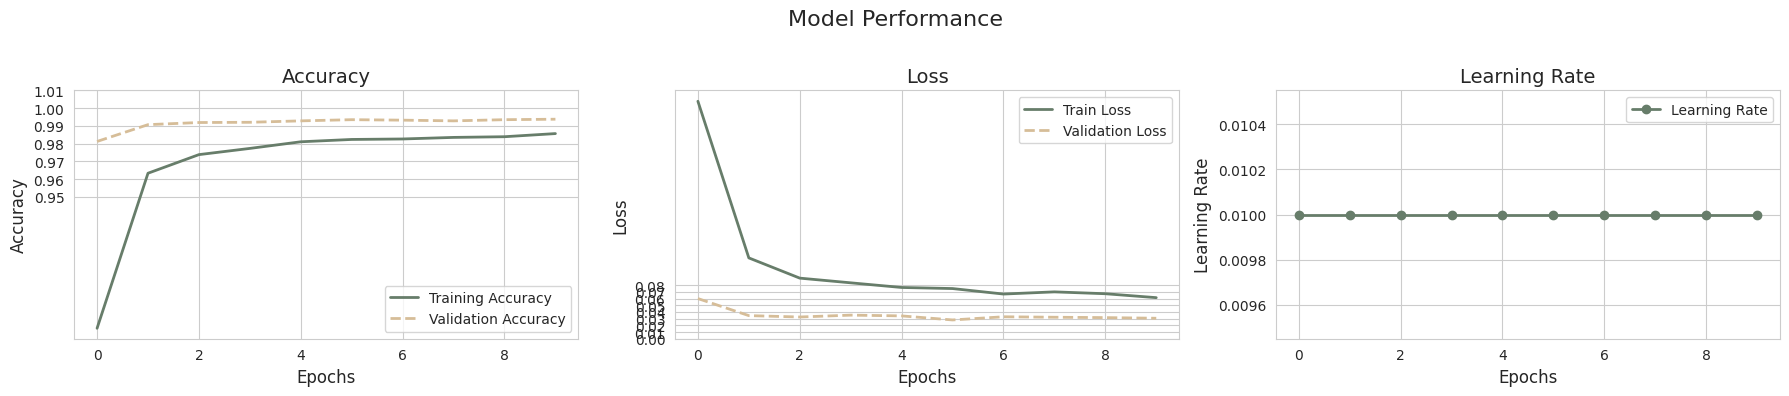

In [34]:
x=np.arange(len(result_df))

fig,ax = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("Model Performance",fontsize=16)

ax[0].plot(x,result_df.accuracy,label='Training Accuracy',linewidth = 2,color = '#677D6A')
ax[0].plot(x,result_df.val_accuracy,label = 'Validation Accuracy', linewidth = 2 ,linestyle = '--',color='#D6BD98')
ax[0].set_title('Accuracy', fontsize=14)
ax[0].set_yticks(np.arange(0.95, 1.01, 0.01))
ax[0].set_xticks(np.arange(0, len(result_df), 2))
ax[0].set_xlabel('Epochs', fontsize=12)
ax[0].set_ylabel('Accuracy', fontsize=12)
ax[0].legend()
ax[0].grid(True)

ax[1].plot(x, result_df.loss, label='Train Loss', linewidth=2, color='#677D6A')
ax[1].plot(x, result_df.val_loss, label='Validation Loss', linewidth=2, linestyle='--', color='#D6BD98')
ax[1].set_title('Loss', fontsize=14)
ax[1].set_xticks(np.arange(0, len(result_df), 2))
ax[1].set_yticks(np.arange(0, 0.085, 0.01))
ax[1].set_xlabel('Epochs', fontsize=12)
ax[1].set_ylabel('Loss', fontsize=12)
ax[1].legend()
ax[1].grid(True)

ax[2].plot(x, result_df.learning_rate, label='Learning Rate', linewidth=2, marker='o', color='#677D6A')
ax[2].set_title('Learning Rate', fontsize=14)
ax[2].set_xticks(np.arange(0, len(result_df), 2))
ax[2].set_xlabel('Epochs', fontsize=12)
ax[2].set_ylabel('Learning Rate', fontsize=12)
ax[2].legend()
ax[2].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

In [50]:
print('Model Evaluation Results:')
print(colored(f'Loss: {loss:.5f}','red',attrs=['bold']))
print(colored(f'Accuracy: {accuracy:.5f}','green',attrs=['bold']))

Model Evaluation Results:
Loss: 0.02782
Accuracy: 0.99360


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


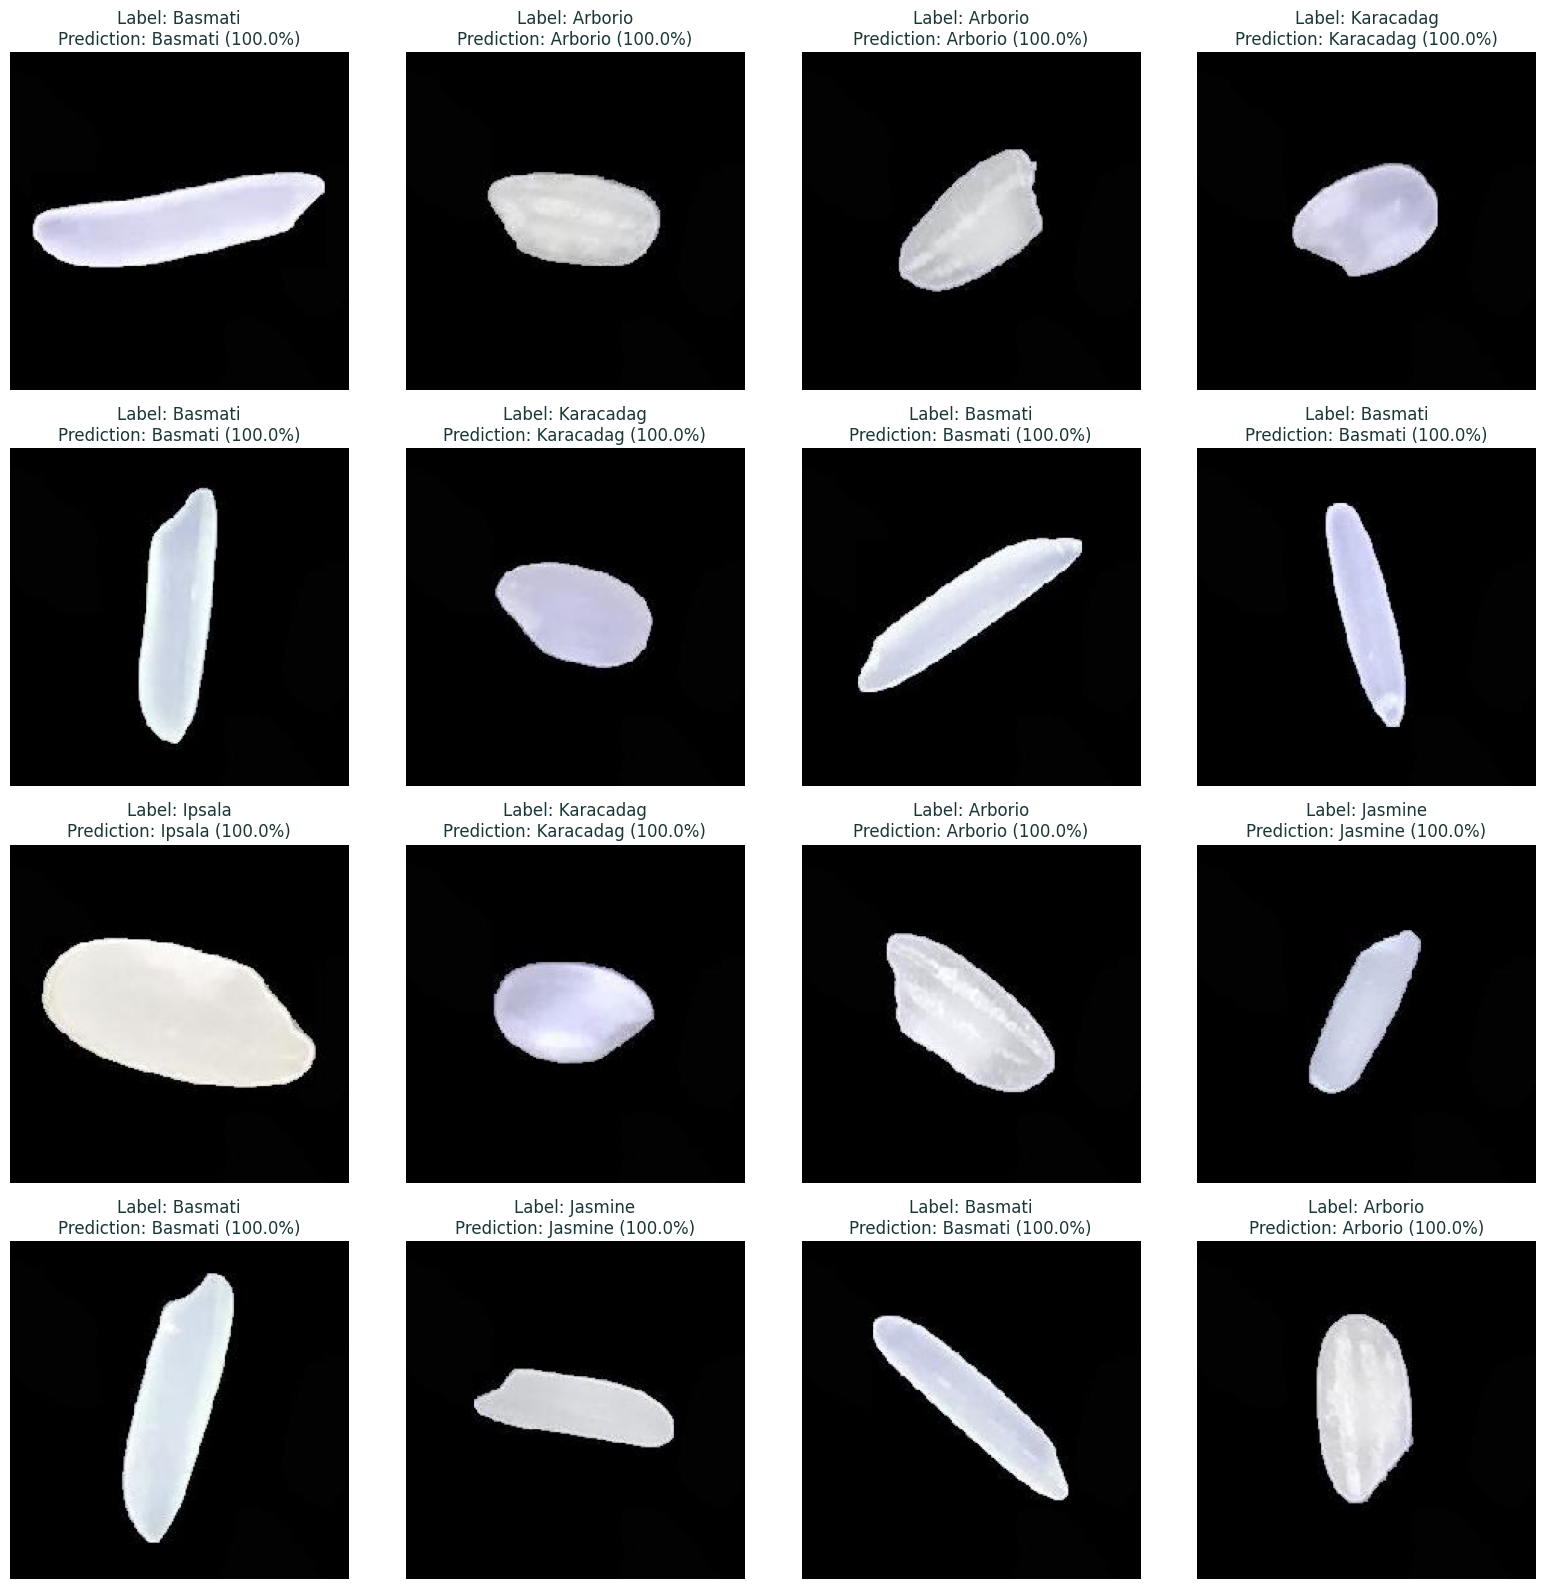

In [51]:
test_generator.reset()

img, label = next(test_generator)

predictions = model.predict(img)

test_pred_classes = np.argmax(predictions, axis=1)

plt.figure(figsize=[16, 16])

for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(img[i])
    plt.axis('off')  

    plt.title(f"Label: {detection[np.argmax(label[i])]}\n"
              f"Prediction: {detection[test_pred_classes[i]]} "
              f"({100 * np.max(predictions[i]):.1f}%)",
              fontsize=12, color='#1A3636')

plt.tight_layout()
plt.show()

In [52]:
y_pred = model.predict(test_generator)

y_pred_classes = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
clf = classification_report(test_generator.classes, y_pred_classes, target_names=detection)

print("="*50)
print("Detailed Classification Report")
print("="*50)
print(clf)
print("="*50)

469/469 ━━━━━━━━━━━━━━━━━━━━ -18287s 57ms/step

Classification Report:
Detailed Classification Report
              precision    recall  f1-score   support

     Arborio       0.99      0.99      0.99      1515
     Basmati       0.99      0.99      0.99      1510
      Ipsala       1.00      1.00      1.00      1480
     Jasmine       0.99      0.99      0.99      1463
   Karacadag       0.99      1.00      0.99      1532

    accuracy                           0.99      7500
   macro avg       0.99      0.99      0.99      7500
weighted avg       0.99      0.99      0.99      7500



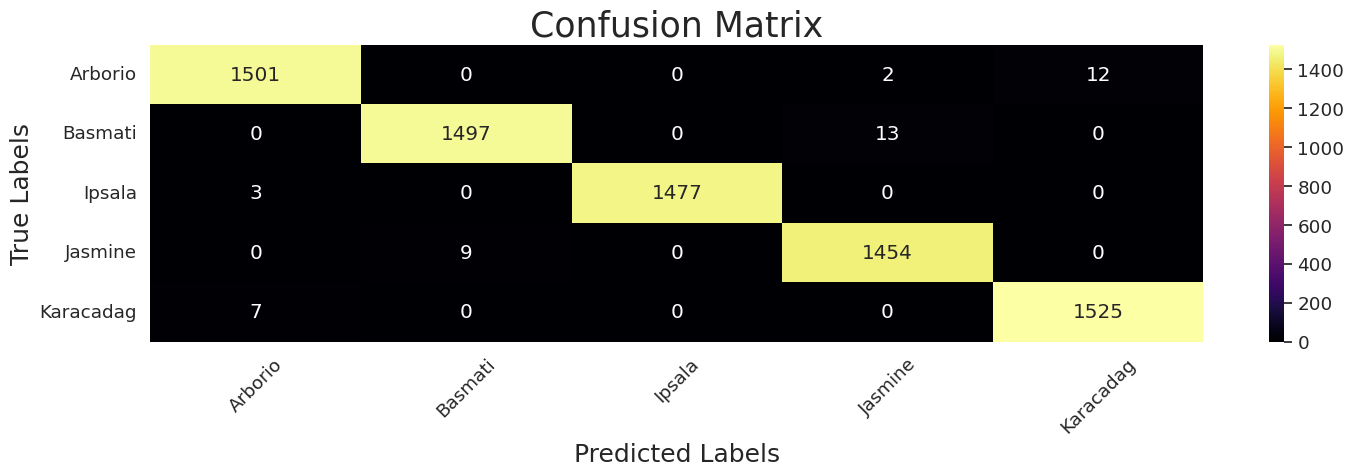

In [54]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(15, 5))
    sns.set(font_scale=1.2)  
    
    ax = sns.heatmap(cm, annot=True, fmt='g', cmap="inferno", cbar=True)
    
    ax.set_xlabel('Predicted Labels', fontsize=18)
    ax.set_ylabel('True Labels', fontsize=18)
    ax.set_title('Confusion Matrix', fontsize=25)
    
    ax.xaxis.set_ticklabels(detection, rotation=45)
    ax.yaxis.set_ticklabels(detection, rotation=0)

    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()

plot_confusion_matrix(test_generator.classes, y_pred_classes)